In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


In [216]:
minimum_date = datetime.fromisoformat('2021-01-01 00:00:00+00:00')
maximum_date = datetime.fromisoformat('2022-01-01 00:00:00+00:00')
minimum_volume = 1000000
resolution = '1h'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

#perps = ['BTC-PERP', 'ETH-PERP', 'SOL-PERP', 'AVAX-PERP', 'MATIC-PERP', 'XRP-PERP', 'BNB-PERP', 'AAVE-PERP', 'ADA-PERP', 'LINK-PERP', 'DOT-PERP', 'FTT-PERP', 'DOGE-PERP', 'SAND-PERP', 'LTC-PERP', 'TRX-PERP', 'BCH-PERP', 'AXS-PERP', 'EOS-PERP', 'SNX-PERP', 'SUSHI-PERP', 'ETC-PERP', 'ALT-PERP', 'SHIT-PERP', 'DEFI-PERP', 'ZEC-PERP', 'XMR-PERP', 'PRIV-PERP']
#perps = ['ZEC-PERP', 'XMR-PERP']

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('/Users/walidmadaoui/Desktop/ARB/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices_df = pd.DataFrame(prices)[minimum_date:maximum_date].T.dropna().T

prices_df

,1INCH-PERP,AAVE-PERP,ADA-PERP,ALGO-PERP,ALT-PERP,ASD-PERP,ATOM-PERP,AVAX-PERP,BAL-PERP,BCH-PERP,...,TRX-PERP,UNI-PERP,USDT-PERP,VET-PERP,WAVES-PERP,XLM-PERP,XRP-PERP,XTZ-PERP,YFI-PERP,ZEC-PERP
startTime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.3261,88.22,0.180705,0.3467,1044.25,0.03654,6.4205,3.264,13.9100,342.15,...,0.026805,5.235,1.0008,0.019235,6.2835,0.128950,0.221425,2.0096,22875.0,64.78
2021-01-01 01:00:00+00:00,1.3006,87.70,0.183890,0.3456,1065.25,0.03654,6.3325,3.177,14.1225,350.35,...,0.027195,5.177,1.0009,0.019875,6.2485,0.133275,0.223550,2.0651,23005.0,65.68
2021-01-01 02:00:00+00:00,1.2799,88.14,0.184100,0.3554,1067.15,0.03654,6.3920,3.106,14.1500,354.95,...,0.027258,5.196,1.0011,0.019840,6.2140,0.132900,0.223400,2.0869,23225.0,65.79
2021-01-01 03:00:00+00:00,1.2617,88.62,0.183250,0.3603,1067.30,0.03654,6.1835,3.129,14.2175,351.50,...,0.027152,5.170,1.0011,0.019635,6.1795,0.131025,0.227200,2.0780,23290.0,65.57
2021-01-01 04:00:00+00:00,1.2438,87.55,0.182065,0.3536,1065.10,0.03655,6.0945,3.108,14.0950,348.85,...,0.027040,5.127,1.0011,0.019760,6.1720,0.133600,0.239275,2.0413,22895.0,65.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 20:00:00+00:00,2.3493,250.64,1.289500,1.6476,4331.80,0.32992,30.7130,106.980,17.0550,420.35,...,0.073637,16.834,1.0000,0.081050,14.1925,0.259625,0.813475,4.2015,31250.0,143.37
2021-12-31 21:00:00+00:00,2.4013,256.22,1.313255,1.7003,4392.55,0.32994,31.5155,108.897,17.4875,428.25,...,0.074887,17.023,1.0000,0.082775,14.5050,0.265700,0.828025,4.2988,32445.0,145.65
2021-12-31 22:00:00+00:00,2.3848,257.01,1.307955,1.6781,4383.50,0.32968,32.9025,111.673,17.4225,430.30,...,0.074853,17.037,1.0000,0.082875,14.5400,0.266775,0.824775,4.3183,33150.0,145.42


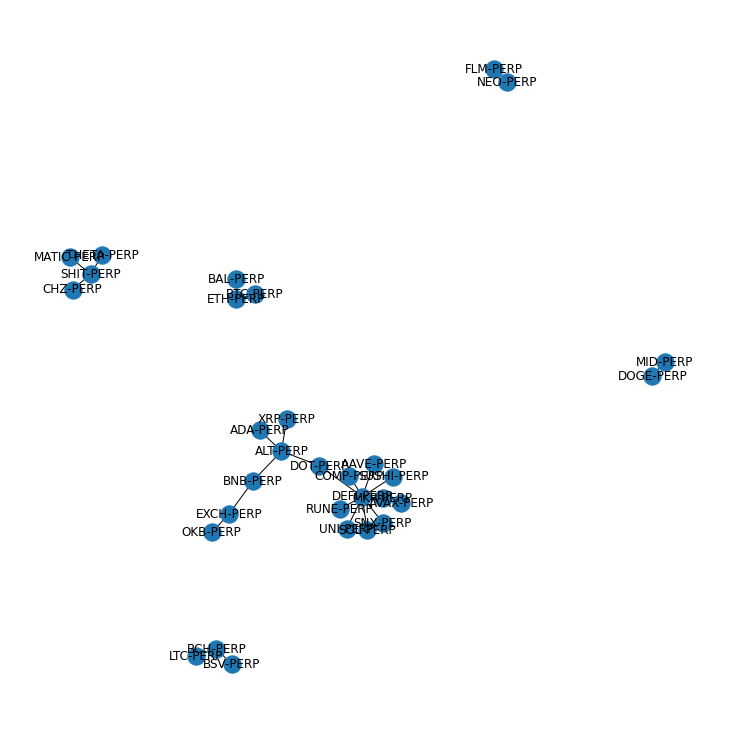

In [414]:
returns = prices_df.pct_change()[1:]
log_returns = np.log1p(returns)

edge_model = covariance.GraphicalLassoCV()
log_returns /= log_returns.std(axis=0)
#returns /= returns.std(axis=0)
edge_model.fit(log_returns)
#edge_model.fit(returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=prices_df.columns, index=prices_df.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.13) &  (links['var1'] != links['var2']) ]
#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

In [415]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


In [433]:
# Find most mean reverting pairs
ridge = RidgeCV()

possible_pairs = {}
clusters = nx.connected_components(G)
for cluster in clusters:
    perps = list(cluster)
    for perp_a in perps:
        for perp_b in perps:
            pair = '{}/{}'.format(perp_b, perp_a)
            if perp_a != perp_b and pair not in possible_pairs.keys():
                # regress log prices
                jres = calculate_johansen(np.log(prices_df[[perp_a, perp_b]]), 1, 2)
                cointegrated = jres.r > 0
                ridge_reg = ridge.fit(np.log(prices_df[perp_a]).values.reshape(-1, 1), np.log(prices_df[perp_b]).values.reshape(-1, 1))

                # test for mean-reversion
                spread = prices_df[perp_b] - ridge_reg.coef_[0][0] * prices_df[perp_a]
                half_life = calculat_half_life(spread)
                adf = adfuller(spread, 1)
                hurst = calculate_hurst(spread)

                possible_pairs[pair] = {
                    'ridge': ridge_reg.coef_[0][0],
                    'eigenvector': jres.evec[0],
                    'cointegrated': cointegrated,
                    'rank': jres.r,
                    'hl': half_life,
                    'adf_pvalue': adf[1],
                    'hurst': hurst
                }

possible_pairs = pd.DataFrame(possible_pairs).T
#possible_pairs[:5]

In [435]:
filtered_pairs = possible_pairs.loc[(possible_pairs['hurst'] < 0.5) & (possible_pairs['rank'] > 0) & (possible_pairs['adf_pvalue'] < 0.01)]
filtered_pairs


,ridge,eigenvector,cointegrated,rank,hl,adf_pvalue,hurst
AAVE-PERP/OKB-PERP,0.227278,"[0.6194738028270173, 2.1771324319933596]",True,1,296.890931,0.00935,0.46263
AAVE-PERP/RUNE-PERP,0.34748,"[0.562871804469988, 2.096189909567236]",True,1,295.206451,0.009007,0.462616
DEFI-PERP/EXCH-PERP,0.533746,"[2.0626516805487816, -2.958996709859985]",True,2,270.054843,0.007307,0.44451
AAVE-PERP/UNI-PERP,0.720575,"[0.3466003627379589, 5.053518561318179]",True,2,288.987888,0.008235,0.463489
AAVE-PERP/XRP-PERP,0.340238,"[0.7129382016394986, 2.315878530356527]",True,1,295.22973,0.008968,0.462719
RUNE-PERP/AAVE-PERP,1.021191,"[2.313376257420918, -2.9154015516823275]",True,1,295.326019,0.009122,0.462417
UNI-PERP/AAVE-PERP,1.058597,"[2.616018702920946, -5.554667149943617]",True,2,287.005939,0.008015,0.463742
XRP-PERP/AAVE-PERP,0.671122,"[2.379827026589914, -2.433133876697443]",True,1,295.271288,0.008998,0.462705
ADA-PERP/AAVE-PERP,0.829708,"[1.8248543034161635, -2.920670858298082]",True,2,295.790585,0.009116,0.46281
SUSHI-PERP/AAVE-PERP,1.036055,"[6.763040303742591, -2.588197325439931]",True,2,291.705986,0.008489,0.463647


In [444]:
possible_pairs.sort_values('hl')[:20]

,ridge,eigenvector,cointegrated,rank,hl,adf_pvalue,hurst
LTC-PERP/BSV-PERP,0.712496,"[5.697629101791724, -2.691325366772315]",True,2,164.042135,0.001261,0.430462
BSV-PERP/LTC-PERP,0.911727,"[6.997398535340252, 1.3578946891893964]",True,2,170.289582,0.001046,0.404637
AAVE-PERP/COMP-PERP,0.853506,"[4.277661599089118, -5.038172755015705]",True,1,237.929814,0.013783,0.442776
DEFI-PERP/EXCH-PERP,0.533746,"[2.0626516805487816, -2.958996709859985]",True,2,270.054843,0.007307,0.44451
SUSHI-PERP/SNX-PERP,0.684636,"[1.748351669753943, -3.152049815162377]",False,0,284.065447,0.01656,0.436549
UNI-PERP/AAVE-PERP,1.058597,"[2.616018702920946, -5.554667149943617]",True,2,287.005939,0.008015,0.463742
AAVE-PERP/UNI-PERP,0.720575,"[0.3466003627379589, 5.053518561318179]",True,2,288.987888,0.008235,0.463489
SNX-PERP/AAVE-PERP,0.751655,"[3.605894042867509, -1.2782600829963515]",False,0,289.560434,0.007769,0.46373
SUSHI-PERP/AAVE-PERP,1.036055,"[6.763040303742591, -2.588197325439931]",True,2,291.705986,0.008489,0.463647
AAVE-PERP/SUSHI-PERP,0.800448,"[4.474188485733619, -4.5258487611880245]",True,2,292.322134,0.00857,0.463488
